# Predict the scores of LLMs on the full LongBench benchmark

In this notebook, we show how to obtain minilongbench socres by predicting the scores of LLMs on the full LongBench benchmark

## Prepare data

In [1]:
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from irt import *
from utils import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
to_handle_scenario = 'longbench'
scenarios

{'longbench': ['LongBench_2wikimqa',
  'LongBench_dureader',
  'LongBench_gov_report',
  'LongBench_hotpotqa',
  'LongBench_lcc',
  'LongBench_lsht',
  'LongBench_multifieldqa_en',
  'LongBench_multifieldqa_zh',
  'LongBench_multi_news',
  'LongBench_musique',
  'LongBench_narrativeqa',
  'LongBench_passage_count',
  'LongBench_passage_retrieval_en',
  'LongBench_passage_retrieval_zh',
  'LongBench_qasper',
  'LongBench_qmsum',
  'LongBench_repobench-p',
  'LongBench_samsum',
  'LongBench_trec',
  'LongBench_triviaqa',
  'LongBench_vcsum']}

Loading longbench test data:

In [3]:
with open('data/longbench.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [4]:
scenarios_position, subscenarios_position = prepare_data(scenarios, data)
Y = create_responses(scenarios, data)

Y.shape

(40, 4750)

In [5]:
balance_weights = np.ones(Y.shape[1])
# per_scen indicates which scenario this document belongs to
per_scen = [1, 1, 2, 1, 5, 3, 0, 0, 2, 1, 0, 4, 4, 4, 0, 2, 5, 3, 3, 3, 2]
N = len(scenarios_position[to_handle_scenario])
n_sub = len(scenarios[to_handle_scenario])
for i, sub in enumerate(scenarios[to_handle_scenario]):
    if per_scen[i] == 4:
        num = 3
    elif per_scen[i] == 5:
        num = 2
    else:
        num = 4
    n_i = len(subscenarios_position[to_handle_scenario][sub])
    balance_weights[subscenarios_position[to_handle_scenario][sub]] = N/(num*6*n_i)  

## Split the data in train and test

In [6]:
train_idx = [32, 30, 25, 8, 0, 26, 7, 29, 12, 9, 23, 21, 1, 39, 6, 14, 11, 27, 20, 10]
test_idx = [13, 34, 3, 38, 22, 24, 35, 37, 5, 4, 2, 19, 28, 33, 17, 18, 15, 36, 16, 31]

Y_test = Y[test_idx]
Y_train = Y[train_idx]
Y_test_set = Y[test_idx]

print(Y.shape, Y_train.shape, Y_test.shape)

(40, 4750) (20, 4750) (20, 4750)


## predict the scores of LLMs on the full LongBench benchmark

By using the previously constructed model, we predict the scores of all LLMs, test LLMs, and training LLMs on Longbench, which will serve as the scores for minilongbench.

In [7]:
# number_item = Y_train.shape[1]
from scipy.stats import spearmanr, pearsonr, kendalltau

scenario_dict = {"Single-Document QA":["LongBench_narrativeqa", "LongBench_qasper", "LongBench_multifieldqa_en", "LongBench_multifieldqa_zh"],
                "Multi-Document QA":["LongBench_hotpotqa", "LongBench_2wikimqa", "LongBench_musique", "LongBench_dureader"],
                "Summarization":["LongBench_gov_report", "LongBench_qmsum", "LongBench_vcsum", "LongBench_samsum"],
                "Few-shot Learning":["LongBench_trec", "LongBench_lsht", "LongBench_triviaqa", "LongBench_multi_news"],
                "Code Completion":["LongBench_lcc", "LongBench_repobench-p"],
                "Synthetic Task":["LongBench_passage_count", "LongBench_passage_retrieval_en", "LongBench_passage_retrieval_zh"]}


A, B, _ = load_irt_parameters('data/irt_model/')
X = np.vstack((A.squeeze(), B.squeeze().reshape((1,-1)))).T
# X = np.vstack((A.squeeze())).T
X = X[scenarios_position['longbench']]
norm_balance_weights = balance_weights[scenarios_position['longbench']]
norm_balance_weights /= norm_balance_weights.sum()
scenario = 'longbench'
with open('data/sub_scenarios_pospos.pkl', 'rb') as f:
    sub_scenarios_pospos = pickle.load(f)
    
whole_sp = []
test_sp = []
train_sp = []
whole_error = []
test_error = []
train_error = []
whole_sub_sp = [[] for i in range(6)]
test_sub_sp = [[] for i in range(6)]
train_sub_sp = [[] for i in range(6)]
whole_sub_score = [[] for i in range(6)]
test_sub_score = [[] for i in range(6)]
train_sub_score = [[] for i in range(6)]
whole_sub_pred_score = [[] for i in range(6)]
test_sub_pred_score = [[] for i in range(6)]
train_sub_pred_score = [[] for i in range(6)]

ratio = 0.95
number_item = int((1-ratio) * 4750)

for e in range(3):
    # eval on all LLMs
    if e == 0:
        Y_test = Y
    # eval on test LLMs
    elif e == 1:
        Y_test = Y_test_set
    # eval on train LLMs
    else:
        Y_test = Y_train

    # Load the test cases of MiniLongBench
    with open("data/anchor.pkl", "rb") as f:
        anchor_points = pickle.load(f)


    for scenario in scenarios.keys():
        Y_anchor = Y_test[:,scenarios_position[scenario]][:,anchor_points[scenario]]
        true = (balance_weights*Y_test)[:,scenarios_position[scenario]].mean(axis=1) # True performance

    # minilongbench test cases
    seen_items = np.hstack([np.array(scenarios_position[scenario])[anchor_points[scenario]] for scenario in scenarios.keys()]).tolist()
    unseen_items = [i for i in range(Y_train.shape[1]) if i not in seen_items]

    # train the theta parameters of the LLM
    thetas = [estimate_ability_parameters(Y_test[j][seen_items], A[:, :, seen_items], B[:, :, seen_items]) for j in range(Y_test.shape[0])]


    preds = {}
    pirt_preds = {}
    for scenario in scenarios.keys():
        if scenario != to_handle_scenario:
            continue
        ind_seen = [u for u in seen_items if u in scenarios_position[scenario]]
        ind_unseen = [u for u in unseen_items if u in scenarios_position[scenario]]
        pirt_lambd = Y_anchor.shape[1]/len(scenarios_position[scenario])

        Y_pred = np.zeros_like(Y_test)
        pirt_pred = []

        # predict the scores of each LLM on Longbench
        for j in range(Y_test.shape[0]):
            Y_pred[j][ind_seen] = (Y_test)[j,ind_seen]
            Y_pred[j][ind_unseen] = (item_curve(thetas[j], A, B))[0,ind_unseen]
            data_part = (balance_weights*Y_test)[j,ind_seen].mean()
            irt_part = (balance_weights*item_curve(thetas[j], A, B))[0,ind_unseen].mean()
            pirt_pred.append(pirt_lambd*data_part + (1-pirt_lambd)*irt_part) 

        pirt_preds[scenario] = np.array(pirt_pred) # Predictions
        pred_scores = (balance_weights*Y_pred)[:,scenarios_position[scenario]].mean(axis=1) # Pred performance
        true = (balance_weights*Y_test)[:,scenarios_position[scenario]].mean(axis=1) # True performance


        # calculate the Spearman rank correlation coefficient
        spearman_corr, spearman_p_value = spearmanr(pred_scores, true)


        if e == 0:
            whole_sp.append(spearman_corr)
            whole_error.append(np.abs(pirt_preds[scenario]-true).mean())
        elif e == 1:
            test_sp.append(spearman_corr)
            test_error.append(np.abs(pirt_preds[scenario]-true).mean())
        else:
            train_sp.append(spearman_corr)
            train_error.append(np.abs(pirt_preds[scenario]-true).mean())


        # calculate the rank correlation coefficient for each sub-scenario.
        sub_scenarios_scores = [[] for i in range(6)]
        sub_scenarios_pred_scores = [[] for i in range(6)]
        sub_scenarios_lens = [[] for i in range(6)]
        sub_scenarios = list(scenario_dict.keys())
        sub_sub_scenarios = list(scenario_dict.values())
        for sub in scenarios[to_handle_scenario]:
            for i in range(6):
                if sub in sub_sub_scenarios[i]:
                    idx = subscenarios_position[to_handle_scenario][sub]
                    if len(sub_scenarios_scores[i]) == 0:
                        sub_scenarios_scores[i] = Y_test[:, idx] 
                        sub_scenarios_pred_scores[i] = Y_pred[:, idx] 
                    else:
                        sub_scenarios_scores[i] = np.concatenate((sub_scenarios_scores[i], Y_test[:, idx] ), axis=1)
                        sub_scenarios_pred_scores[i] = np.concatenate((sub_scenarios_pred_scores[i], Y_pred[:, idx]), axis=1)
                    sub_scenarios_lens[i].append(len(idx))
                    break

        for i in range(6):
            tmp_score = sub_scenarios_pred_scores[i].mean(axis=1)
            spearman_corr, spearman_p_value = spearmanr(sub_scenarios_scores[i].mean(axis=1), tmp_score)
            if e == 0:
                whole_sub_sp[i].append(spearman_corr)
                whole_sub_score[i].append(sub_scenarios_scores[i].mean(axis=1))
                whole_sub_pred_score[i].append(tmp_score)
            elif e == 1:
                test_sub_sp[i].append(spearman_corr)
                test_sub_score[i].append(sub_scenarios_scores[i].mean(axis=1))
                test_sub_pred_score[i].append(tmp_score)
            else:
                train_sub_sp[i].append(spearman_corr)
                train_sub_score[i].append(sub_scenarios_scores[i].mean(axis=1))
                train_sub_pred_score[i].append(tmp_score)
print(whole_sp, test_sp, train_sp)
print(list(pred_scores), list(true))

[0.9667917448405254] [0.9624060150375938] [0.9849624060150375]
[0.1462724171932862, 0.20236508990563512, 0.20702941585238147, 0.2461165981793714, 0.254060580089826, 0.2562535851176376, 0.26384002212403773, 0.25273784040704006, 0.26849787401355835, 0.25489545545538606, 0.2716078945889935, 0.2571147438514828, 0.28178350520295314, 0.2954944995934341, 0.3019402083182284, 0.3009922423102326, 0.2855651149890337, 0.3084157444643796, 0.3038842256561778, 0.36436433242249544] [0.16220883817237422, 0.22861466891008259, 0.2287018724646061, 0.26203051665900146, 0.27283129537498496, 0.2765144368268408, 0.2789991445277246, 0.2727940202053576, 0.2815015378117482, 0.26807161505418764, 0.2859295884488266, 0.2753977890536452, 0.28798126336894053, 0.29269813490741214, 0.3065134940163583, 0.3104894474313418, 0.30854571883991305, 0.32150792931739514, 0.32569253727399594, 0.3751365903795538]


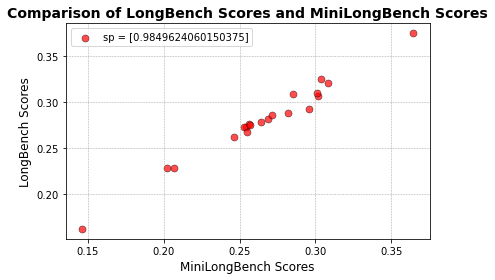

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 4)) 
plt.scatter(pred_scores, true, color='red', alpha=0.7, s=50, edgecolor='black', linewidth=0.5, label=f'sp = {train_sp}')


plt.title('Comparison of LongBench Scores and MiniLongBench Scores', fontsize=14, fontweight='bold')
plt.xlabel('MiniLongBench Scores', fontsize=12)
plt.ylabel('LongBench Scores', fontsize=12)

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=10, loc='upper left')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()  
plt.show()